In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm
import torch.optim as optim
import os
import sys

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[2]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 12

In [4]:
with h5py.File('../../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]
test_y = pd.read_parquet('../../../data/3d_array/test_targets.parquet')

test_X = np.nan_to_num(test_X, nan=0.0)

In [5]:
test_y['end_of_month'].value_counts()

end_of_month
2018-03-31    137674
Name: count, dtype: int64

In [6]:
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_15156\204564841.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


In [7]:
test_y

,customer_ID,end_of_month,target
0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-31,0
1,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-31,0
2,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-31,0
3,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,2018-03-31,0
4,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2018-03-31,1
...,...,...,...
137669,fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b1...,2018-03-31,0
137670,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,2018-03-31,0
137671,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0
137672,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-31,0


In [8]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [9]:
class MDC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], num_kernels_per_scale=3):
        super(MDC, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        self.num_scales = len(kernel_sizes)
        self.num_kernels_per_scale = num_kernels_per_scale
        self.total_kernels = self.num_scales * self.num_kernels_per_scale

        # Attention mechanism to generate weights for kernels [cite: 142, 143, 145]
        self.attention_pool = nn.AdaptiveAvgPool1d(1) # Pool across time dimension
        # Conv1d to generate temporal attention map
        self.attention_conv = nn.Conv1d(in_channels, self.total_kernels, kernel_size=1, bias=False)
        self.attention_gap = nn.AdaptiveAvgPool1d(1) # Pool attention map to get weights
        self.attention_activation = nn.Sigmoid()

        # Store the kernels for each scale and each instance per scale
        self.weights = nn.Parameter(torch.Tensor(self.total_kernels, out_channels, in_channels, 1)) # Use kernel_size=1 here, will expand later
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5)) # Initialize weights

        # Store kernel sizes correctly
        self.k_sizes = []
        for k in kernel_sizes:
            for _ in range(num_kernels_per_scale):
                self.k_sizes.append(k)

    def forward(self, x):
        batch_size, _, T = x.size()

        # Calculate attention weights [cite: 142, 145]
        pooled_x = self.attention_pool(x) # B x C_in x 1
        # The paper's diagram (Fig 3) suggests GAP -> Conv -> GAP -> Sigmoid for attention
        # Let's follow the diagram logic more closely:
        # GAP on input: B x C_in x T -> B x C_in x 1
        att_gap1 = self.attention_pool(x)
        # Conv1d on pooled input: B x C_in x 1 -> B x total_kernels x 1 (This seems different from Fig 3's BxmxnxT output)
        # Let's reinterpret Fig 3: GAP(x) [B,Cin,T]->[B,Cin,1], then Conv [B,Cin,1]->[B,mxn,1] (This doesn't match BxmxnxT)
        # Let's try the alternative interpretation from the text (Section 3.2.1, Eq 2 implies GAP -> Conv -> GAP)
        # GAP(x) -> B x Cin x 1
        # wa * GAP(x) -> B x mxn x 1 (This still feels off from Fig 3 which applies conv before second GAP)

        # Let's follow Fig 3 literally (ignoring the first GAP shown before Conv in the Attention block):
        # Conv on input x: B x Cin x T -> B x mxn x T [cite: 143]
        attention_map = self.attention_conv(x) # B x total_kernels x T
        # GAP on attention_map: B x mxn x T -> B x mxn x 1 [cite: 145]
        attention_vector = self.attention_gap(attention_map)
        # Sigmoid activation: B x mxn x 1 [cite: 145]
        attention_weights = self.attention_activation(attention_vector) # Shape: (batch_size, total_kernels, 1)

        # Fuse kernels based on attention weights [cite: 140]
        # Reshape weights for broadcasting: (batch_size, total_kernels, 1) -> (batch_size, total_kernels, 1, 1, 1)
        # Reshape kernels: (total_kernels, out_c, in_c, 1)
        # We need to perform convolution dynamically. PyTorch doesn't easily support dynamic kernel *shapes*.
        # A common approach is to have fixed-size kernels and combine their *outputs*, or combine *weights* for a fixed kernel size.
        # The paper seems to imply combining weights *before* convolution (Eq 1). This requires all kernels w_i^j to have the same size k.
        # However, the goal is *multi-scale*.

        # Let's implement the multi-scale aspect by having separate convolutions and combining outputs weighted by attention.
        # This deviates slightly from Eq 1 but achieves the multi-scale goal.

        outputs = []
        current_kernel_idx = 0
        for k_size in self.kernel_sizes:
            padding = k_size // 2
            for i in range(self.num_kernels_per_scale):
                # Get the weights for this specific kernel instance (across all batches)
                # attention_weights shape: B x total_kernels x 1
                # kernel_weights shape: B x 1 x out_c x in_c x k_size
                kernel_idx = current_kernel_idx + i
                kernel_weight = self.weights[kernel_idx] # out_c x in_c x 1
                # Manually create the kernel for Conv1d for this size
                dynamic_kernel = kernel_weight.repeat(1, 1, k_size) # out_c x in_c x k_size
                
                # Perform convolution with this specific kernel
                output_i = F.conv1d(x, dynamic_kernel, padding=padding) # B x out_c x T
                
                # Apply attention weight for this kernel
                # attention_weights[:, kernel_idx, :] shape: B x 1 x 1
                weighted_output = output_i * attention_weights[:, kernel_idx, :].unsqueeze(-1) # B x out_c x T
                outputs.append(weighted_output)
                
            current_kernel_idx += self.num_kernels_per_scale

        # Sum the weighted outputs from all kernels
        # This is an alternative interpretation to fusing weights first.
        out = torch.sum(torch.stack(outputs), dim=0) # B x out_c x T

        return out

In [10]:
class MDCResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], num_kernels_per_scale=3, stride=1):
        super(MDCResBlock, self).__init__()
        
        # Use Conv1d for the residual connection if dimensions change
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.mdc1 = MDC(in_channels, out_channels, kernel_sizes, num_kernels_per_scale)
        self.bn1 = nn.BatchNorm1d(out_channels)
        # Paper uses PReLU, let's use ReLU for simplicity or add PReLU if needed. Using PReLU as per paper.
        self.prelu1 = nn.PReLU(out_channels)

        self.mdc2 = MDC(out_channels, out_channels, kernel_sizes, num_kernels_per_scale)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.prelu2 = nn.PReLU(out_channels) # Activation after final BN before adding shortcut

    def forward(self, x):
        shortcut = self.shortcut(x)

        out = self.mdc1(x)
        out = self.bn1(out)
        out = self.prelu1(out)

        out = self.mdc2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.prelu2(out) # Final activation after adding shortcut

        return out

In [11]:
class MDCNet(nn.Module):
    def __init__(self, input_channels, num_classes, block_channels=[128, 128, 128], kernel_sizes=[3,5,7], num_kernels_per_scale=2, dropout_rate=0.3, reduction=16):
        super(MDCNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        current_channels = input_channels
        
        # Configuration from paper/Figure 2: 3 Blocks [cite: 130]
        # Each block: MDC ResBlock -> MaxPool -> SE -> Dropout
        for i, channels in enumerate(block_channels):
            # Stride only applied if pooling happens, MaxPooling handles stride=2
            res_block = MDCResBlock(current_channels, channels, kernel_sizes, num_kernels_per_scale, stride=1)
            max_pool = nn.MaxPool1d(kernel_size=2, stride=2) # Halve the length [cite: 132]
            se_block = SEBlock(channels, reduction) # SE block [cite: 133]
            dropout = nn.Dropout(dropout_rate) # Dropout [cite: 134]
            
            block = nn.Sequential(
                res_block,
                max_pool,
                se_block,
                dropout
            )
            self.blocks.append(block)
            current_channels = channels # Update channels for next block

        self.gap = nn.AdaptiveAvgPool1d(1) # Global Average Pooling [cite: 130]
        # The original ConvModel in experiment_10 has FC layers after pooling.
        # MDCNet in the paper feeds features to DPNet or directly to Softmax.
        # To make it a component usable in the existing structure, we output features before FC layers.
        self.output_channels = current_channels

    def forward(self, x):
        # Input x shape: B x T x C_in (e.g., B x 10 x 115)
        # Conv1D expects B x C_in x T
        x = x.permute(0, 2, 1) # B x C_in x T (e.g., B x 115 x 10)

        for block in self.blocks:
            x = block(x)

        # Global Average Pooling
        x = self.gap(x) # B x C_out x 1
        x = x.view(x.size(0), -1) # Flatten: B x C_out

        return x

In [12]:
class ModifiedConvModel(nn.Module):
    def __init__(self, input_size, time_steps, num_classes=1, mdc_block_channels=[64, 64, 64], mdc_kernel_sizes=[3,5,7], mdc_kernels_per_scale=2, dropout_rate=0.2, fc_size=32):
        super(ModifiedConvModel, self).__init__()
        
        # Instantiate MDCNet feature extractor
        self.mdc_net = MDCNet(input_channels=input_size,
                              num_classes=num_classes, # Not directly used by MDCNet output layer here
                              block_channels=mdc_block_channels,
                              kernel_sizes=mdc_kernel_sizes,
                              num_kernels_per_scale=mdc_kernels_per_scale,
                              dropout_rate=dropout_rate)
        
        # Get the output feature dimension from MDCNet
        mdc_output_channels = self.mdc_net.output_channels

        # Fully connected layers (similar to original experiment_10)
        self.fc1 = nn.Linear(mdc_output_channels, fc_size)
        self.relu_fc = nn.ReLU() # Added ReLU after FC1
        self.fc2 = nn.Linear(fc_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features
        
        # Pass through MDCNet feature extractor
        features = self.mdc_net(x) # Output: B x mdc_output_channels
        
        # Fully connected layers
        x = self.fc1(features)
        x = self.relu_fc(x)
        x = self.fc2(x)
        
        # Output probability
        return self.sigmoid(x)

In [13]:
# Initialize the Modified ConvModel
input_size = test_X.shape[2]  # Number of features (115)
time_steps = test_X.shape[1]  # Number of time steps (10)
output_size = 1  # Binary classification

In [14]:
# --- MDCNet Hyperparameters ---
# Using smaller channels than paper's example for potentially faster training/less memory
mdc_block_channels = [16,16,16] # Example channel sizes for each block
# Using kernel sizes mentioned in paper, and n=2 as found via cross-validation in paper [cite: 242, 243]
mdc_kernel_sizes = [3, 5, 7]
mdc_kernels_per_scale = 2
dropout_rate = 0.2 # Adjusted dropout
fc_size = 16 # Adjusted FC size

# Create model instance
model = ModifiedConvModel(input_size=input_size,
                          time_steps=time_steps,
                          num_classes=output_size,
                          mdc_block_channels=mdc_block_channels,
                          mdc_kernel_sizes=mdc_kernel_sizes,
                          mdc_kernels_per_scale=mdc_kernels_per_scale,
                          dropout_rate=dropout_rate,
                          fc_size=fc_size)

print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [15]:
# Define the model path
model_path = f'../../../models/deep_learning/experiment_{experiment_num}.pth'

# Load the model parameters
try:
    # Load the saved dictionary
    checkpoint = torch.load(model_path)
    
    # Extract model parameters from the 'model_state_dict' key
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model parameters loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    print("Please specify the correct path to the model parameters")
except KeyError:
    print(f"'model_state_dict' key not found in the checkpoint file")
    print("The file may have been saved with a different structure")
except Exception as e:
    print(f"Error loading model parameters: {str(e)}")

Error loading model parameters: Error(s) in loading state_dict for ModifiedConvModel:
	size mismatch for mdc_net.blocks.0.0.shortcut.0.weight: copying a param with shape torch.Size([16, 115, 1]) from checkpoint, the shape in current model is torch.Size([16, 86, 1]).
	size mismatch for mdc_net.blocks.0.0.mdc1.weights: copying a param with shape torch.Size([6, 16, 115, 1]) from checkpoint, the shape in current model is torch.Size([6, 16, 86, 1]).
	size mismatch for mdc_net.blocks.0.0.mdc1.attention_conv.weight: copying a param with shape torch.Size([6, 115, 1]) from checkpoint, the shape in current model is torch.Size([6, 86, 1]).


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_15156\148194223.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [16]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [17]:
batch_size = 10000
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.3500    0.0001    0.0001    102026
           1     0.2589    0.9996    0.4112     35648

    accuracy                         0.2589    137674
   macro avg     0.3044    0.4999    0.2057    137674
weighted avg     0.3264    0.2589    0.1066    137674

Accuracy: 0.2589
ROC-AUC Score: 0.3834

Confusion Matrix:
[[     7 102019]
 [    13  35635]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.9849558
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.7397    0.9800    0.8431    102026
     Class 1     0.1840    0.0129    0.0241     35648

    accuracy                         0.7296    137674
   macro avg     0.4618    0.4965    0.4336    137674
weighted avg     0.5958    0.7296    0.6310    137674



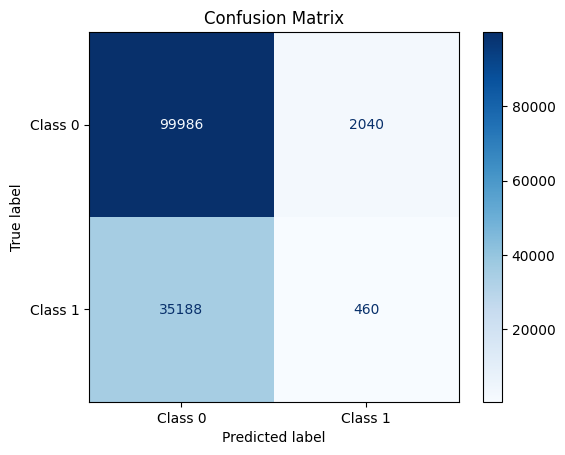

0.9849557876586914

In [19]:
from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)